In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from math import pi

In [2]:
n_samples=1_000

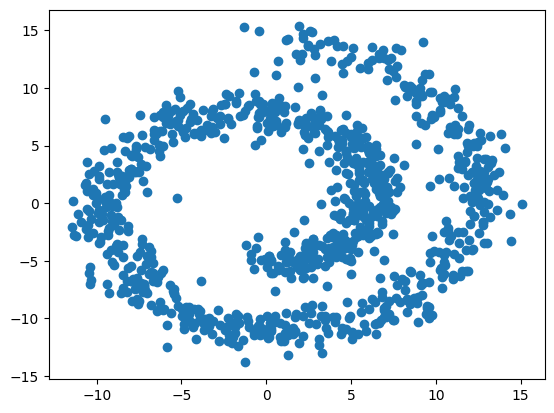

In [3]:
data, _ = make_swiss_roll(n_samples, noise=1)
data = data[:,[0, -1]]
fig=plt.scatter(data[:,0], data[:,1])

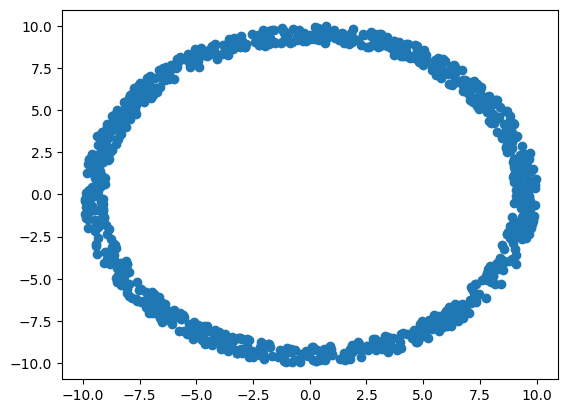

In [4]:
def make_ring(n_samples):
    u = np.random.uniform(low=0, high=2*pi, size=(n_samples,1))
    r = np.random.uniform(low=9, high=10, size=(n_samples,1))
    x = r * np.sin(u)
    y = r * np.cos(u)
    return np.concatenate([x, y], axis=-1), u
    

base, _ = make_ring(n_samples)
fig=plt.scatter(base[:,0], base[:,1])

In [5]:
class FlowMatching(keras.Model):
    def __init__(self, n_units, n_layers, dim=2):
        super(FlowMatching, self).__init__()
        self.dim = dim
        self.velocity = keras.Sequential(
            [keras.layers.Dense(n_units, activation="elu") for _ in range(n_layers)]
            )
        self.velocity.add(keras.layers.Dense(dim))

    def call(self, inputs):
        x_0, x_1, t, condition = inputs.values()
        x_t = (1-t)*x_0 + t*x_1
        x = keras.ops.concatenate([x_t, t, condition], axis=-1)
        return self.velocity(x)

    def step(self, x, t, dt, condition):
        t_start = np.zeros_like(x) + t
        input_start = keras.ops.concatenate([x, t_start, condition], axis=-1)
        v = self.velocity(input_start)
        x_mid = x + v * dt / 2

        t_mid = t_start + dt / 2
        input_mid = keras.ops.concatenate([x_mid, t_mid, condition], axis=-1)
        v = self.velocity(input_mid)
        x_end = x + v * dt

        return x_end

    def run(self, x, steps, condition):
        time = np.linspace(0, 1, steps+1)
        output = []
        output.append(x)
        for i in range(steps):
            x = self.step(x, time[i], time[i+1]-time[i], condition)
            output.append(x)
        
        return output

    def sample(self, n_samples, steps, condition):
        condition = np.array(condition)[np.newaxis,...]
        condition = np.repeat(condition, repeats=n_samples, axis=0)
        
        x_0, u = make_ring(n_samples)
        x_1 = self.run(x_0, steps, condition)
        return np.array(x_1).swapaxes(0, 1), u
        
        

In [6]:
flow = FlowMatching(n_units=64, n_layers=8)

In [7]:
class DataSet(keras.utils.PyDataset):
    def __init__(self, batch_size, n_batches):
        super().__init__()
        self.n_batches=n_batches
        self.batch_size = batch_size
    
    @property
    def num_batches(self):
        return self.n_batches

    def __getitem__(self, index):
        data, _ = make_swiss_roll(self.batch_size, noise=1)
        data = data[:,[0, -1]]
        condition = np.random.choice([1, -1], size=(batch_size, 2))
        data = condition * data

        base, u = make_ring(data.shape[0])
        
        t = np.random.uniform(low=0, high=1, size=data.shape[0])
        t = np.repeat(t[:,np.newaxis], repeats=data.shape[1], axis=1)

        target = data - base
        return dict(x_0=base, x_1=data, t=t, condition=condition), target

In [8]:
def get_lr(optimizer):
    def lr(*args, **kwargs):
        return optimizer.learning_rate
    return lr

In [9]:
epochs=10
batches=1000
batch_size=512

dataset=DataSet(batch_size=batch_size, n_batches=epochs*batches)

schedule = keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.01, decay_steps=epochs*batches)
optimizer = keras.optimizers.Adam(schedule, global_clipnorm=1.0)
lr_metric = get_lr(optimizer)

flow.compile(
    optimizer=optimizer,
    metrics=[lr_metric],
    loss=keras.losses.MeanSquaredError()
)

In [10]:
history=flow.fit(x=dataset, epochs=epochs, steps_per_epoch=batches)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 67.0205 - lr: 0.0100
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 60.5424 - lr: 0.0096
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 59.1689 - lr: 0.0088
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 58.6094 - lr: 0.0076
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 57.8444 - lr: 0.0062
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 57.4598 - lr: 0.0046
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 56.8042 - lr: 0.0031
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 56.4807 - lr: 0.0018
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 56.0494 - lr: 7.4636e-04
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 56.0248 - lr: 1.4953e-04


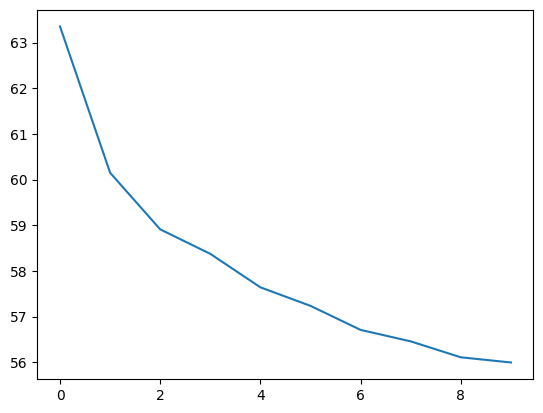

In [11]:
f=plt.plot(history.history["loss"])

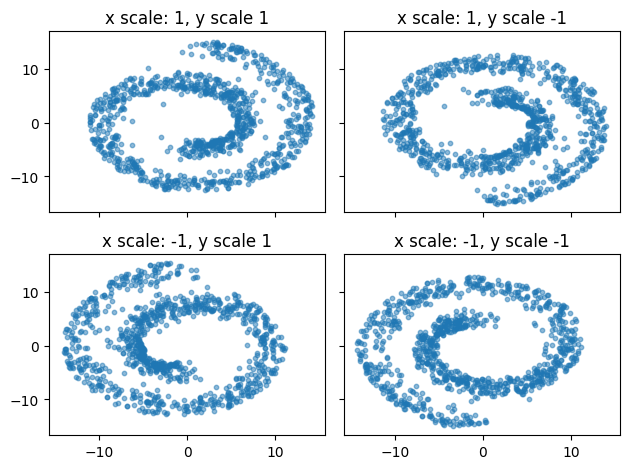

In [12]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
for i, x_scale in enumerate([1, -1]):
    for j, y_scale in enumerate([1, -1]):
        condition = [x_scale, y_scale]
        x, _ = flow.sample(n_samples=n_samples, steps=100, condition=condition)
        axs[i,j].scatter(x[:, -1, 0], x[:, -1, 1], s=10, alpha=0.5)
        axs[i,j].set_title("x scale: {}, y scale {}".format(x_scale, y_scale))
fig.tight_layout()

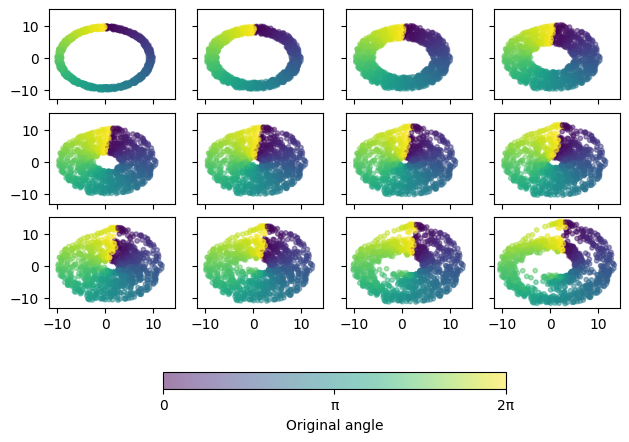

In [26]:
x, u = flow.sample(n_samples=n_samples, steps=12, condition=[1, 1])

fig, axs=plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True)
axs=axs.flatten()

for i in range(12):
    sc=axs[i].scatter(x[:, i, 0], x[:, i, 1], s=10, alpha=0.5, c=u)

fig.tight_layout()
cbar=fig.colorbar(sc, ax=axs, orientation="horizontal", shrink=0.6)
cbar.set_label("Original angle")
cbar.set_ticks([0, np.pi, 2 * np.pi])
cbar.set_ticklabels(['0', 'π', '2π'])
